In [9]:
import json
import os
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
import random
import shutil
import numpy as np
import glob
# import torch
# from torch.utils import data
# from torch.utils.data import DataLoader
import h5py
from scipy import ndimage
from pathlib import Path

## original

In [4]:
threshold = 100  # how the bbox area should be

for set in ['test','train','valid']:
    if set == 'valid': org_set = 'val'
    else: org_set = set
        
    img_path = '/hdd/yuchen/satdata/landslides/{}_numpy_images'.format(org_set)
    label_path = '/hdd/yuchen/satdata/landslides/{}_yolo_labels'.format(org_set)
    output_image_path = '/hdd/yuchen/pipeline/training_pipeline/sat_data/{}/'.format(set)

    files = [file for file in os.listdir(output_image_path) if os.path.isfile(os.path.join(output_image_path, file))]
    for file in files:
        os.remove(os.path.join(output_image_path, file))
    
    for filename_temp in glob.glob(img_path+'/*'):
        filename = filename_temp.split('/')[-1].split('.')[0]
        img = np.load(filename_temp)
        # selected_channels = np.random.choice(7, 3, replace=False)
        selected_channels = np.array([2, 0, 4])
        img = np.moveaxis(img[selected_channels], 0, 2)
        image = Image.fromarray(img, 'RGB')
        
        label = f'{label_path}/{filename}.txt'

        with open(label, 'r') as file:
            file_content = file.read()
            file_content = file_content.split('\n')
        
        lst = [item.split(' ') for item in file_content]
        
        coords = []
        for i in lst:
            coords_temp = []
            for j in i[1:]:
                coords_temp.append(float(j))
            coords.append(np.array(coords_temp, dtype='object').reshape(-1,2))
        
        label_base='<annotation>\n<folder></folder>\n<filename>{}.jpg</filename>\n<path>{}.jpg</path>\n<source>\n<database></database>\n</source>\n<size>\n<width>{}</width>\n<height>{}</height>\n<depth>3</depth>\n</size>\n<segmented>0</segmented>\n'.format(filename,filename, img.shape[0], img.shape[1])
        label_base_end = '</annotation>'

        ct = 0
        for num_labels in range(len(coords)):
            if len(coords[num_labels]) != 0:
                big_x=np.where(coords[num_labels][:,0] == max(coords[num_labels][:,0]))[0][0] # big x
                small_x=np.where(coords[num_labels][:,0] == min(coords[num_labels][:,0]))[0][0] # small x
                big_y=np.where(coords[num_labels][:,1] == max(coords[num_labels][:,1]))[0][0] # big y
                small_y=np.where(coords[num_labels][:,1] == min(coords[num_labels][:,1]))[0][0]# small y
                    
                xmin, ymin = [int(coords[num_labels][small_x][0]*img.shape[0]),
                              int((coords[num_labels][small_y][1])*img.shape[1])]
                xmax, ymax = [int(coords[num_labels][big_x][0]*img.shape[0]), 
                              int((coords[num_labels][big_y][1])*img.shape[1])]

                if xmin<0 or ymin<0 or xmax<0 or ymax<0: continue
                elif xmax-xmin<1 or ymax-ymin<1: continue
                elif (xmax-xmin) *  (ymax-ymin) < threshold: continue
                else:
                    label_name = '<object>\n<name>landslides</name>\n<pose>Unspecified</pose>\n<truncated>0</truncated>\n<difficult>0</difficult>\n<occluded>0</occluded>\n<bndbox><xmin>{}</xmin><xmax>{}</xmax><ymin>{}</ymin><ymax>{}</ymax></bndbox>\n</object>\n'.format(xmin, xmax, ymin, ymax)
                    label_base=label_base+label_name
                    ct += 1
       
        if ct == 0:
            print(filename,'does not have any labels')
        else:
            label_base = label_base+label_base_end
    
            image.save(output_image_path+str(filename)+'.jpg', 'JPEG')
            
            xml_label_path=output_image_path+str(filename)+'.txt'
            with open(xml_label_path, 'w') as file:
                file.write(label_base)
                
            new_file_name = xml_label_path.split('.')[0]+'.xml'
            
            os.rename(xml_label_path, new_file_name)

print()
print('channel', selected_channels)

LT05_L1TP_129038_19870107_20170221_01_T1_patch_3200_640 does not have any labels

channel [2 0 4]


## landslides new

In [29]:
label_path = '/hdd/yuchen/satdata/landslides2/labels/'
image_path =  '/hdd/yuchen/satdata/landslides2/image_patches/'

file_list = glob.glob(label_path+'*.txt')

random_seed = 42
random.seed(random_seed)
random.shuffle(file_list)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_files = len(file_list)

file_num_idx_dict = {
    'train': [0, round(total_files * train_ratio)],
    'valid': [round(total_files * train_ratio), 
              round(total_files * train_ratio) + round(total_files * val_ratio)],
    'test': [round(total_files * train_ratio) + round(total_files * val_ratio), total_files]
}

def copy_files(file_list, destination):
    for f in file_list:
        shutil.copy(f, destination)

for set in ['test','train','valid']:
    set_dir = '/hdd/yuchen/satdata/landslides2/resplit_data/{}/'.format(set)

    files = [file for file in os.listdir(set_dir) if os.path.isfile(os.path.join(set_dir, file))]
    for file in files:
        os.remove(os.path.join(set_dir, file))
    
    set_files = file_list[file_num_idx_dict[set][0]:file_num_idx_dict[set][1]]
    copy_files(set_files, set_dir)
    set_files_img = [f'{image_path}{f.split("/")[-1].split(".")[0]}.npy' for f in set_files]
    copy_files(set_files_img, set_dir)
    

In [94]:
threshold = 100  # how the bbox area should be

for set in ['test','train','valid']:
        
    img_path = '/hdd/yuchen/satdata/landslides2/resplit_data/{}'.format(set)
    label_path = '/hdd/yuchen/satdata/landslides2/resplit_data/{}'.format(set)
    output_image_path = '/hdd/yuchen/pipeline/training_pipeline/data_sat_new/{}/'.format(set)
        
    files = [file for file in os.listdir(output_image_path) if os.path.isfile(os.path.join(output_image_path, file))]
    for file in files:
        os.remove(os.path.join(output_image_path, file))
    
    for filename_temp in glob.glob(img_path+'/*.npy'):
        filename = filename_temp.split('/')[-1].split('.')[0]
        img = np.load(filename_temp)
        
#         # selected_channels = np.random.choice(7, 3, replace=False)
        selected_channels = np.array([0,1,2])
        img = np.moveaxis(img[selected_channels], 0, 2)
        
        for c in range(3):
            min_val = np.nanmin(img[:,:,c])
            # scale_factor = max_val // 255
            scale_factor = 65535 // 255
            img[:,:,c] = (img[:,:,c] / scale_factor).astype(np.uint8)
        image = Image.fromarray(img.astype(np.uint8), 'RGB')
        label = f'{label_path}/{filename}.txt'

        with open(label, 'r') as file:
            file_content = file.read()
            file_content = file_content.split('\n')
        
        lst = [item.split(' ') for item in file_content]
        
        coords = []
        for i in lst:
            coords_temp = []
            for j in i[1:]:
                coords_temp.append(float(j))
            coords.append(np.array(coords_temp, dtype='object').reshape(-1,2))
        
        label_base='<annotation>\n<folder></folder>\n<filename>{}.jpg</filename>\n<path>{}.jpg</path>\n<source>\n<database></database>\n</source>\n<size>\n<width>{}</width>\n<height>{}</height>\n<depth>3</depth>\n</size>\n<segmented>0</segmented>\n'.format(filename,filename, img.shape[0], img.shape[1])
        label_base_end = '</annotation>'

        ct = 0
        for num_labels in range(len(coords)):
            if len(coords[num_labels]) != 0:
                big_x=np.where(coords[num_labels][:,0] == max(coords[num_labels][:,0]))[0][0] # big x
                small_x=np.where(coords[num_labels][:,0] == min(coords[num_labels][:,0]))[0][0] # small x
                big_y=np.where(coords[num_labels][:,1] == max(coords[num_labels][:,1]))[0][0] # big y
                small_y=np.where(coords[num_labels][:,1] == min(coords[num_labels][:,1]))[0][0]# small y
                    
                xmin, ymin = [int(coords[num_labels][small_x][0]*img.shape[0]),
                              int((coords[num_labels][small_y][1])*img.shape[1])]
                xmax, ymax = [int(coords[num_labels][big_x][0]*img.shape[0]), 
                              int((coords[num_labels][big_y][1])*img.shape[1])]

                if xmin<0 or ymin<0 or xmax<0 or ymax<0: continue
                elif xmax-xmin<1 or ymax-ymin<1: continue
                elif (xmax-xmin) *  (ymax-ymin) < threshold: continue
                else:
                    label_name = '<object>\n<name>landslides</name>\n<pose>Unspecified</pose>\n<truncated>0</truncated>\n<difficult>0</difficult>\n<occluded>0</occluded>\n<bndbox><xmin>{}</xmin><xmax>{}</xmax><ymin>{}</ymin><ymax>{}</ymax></bndbox>\n</object>\n'.format(xmin, xmax, ymin, ymax)
                    label_base=label_base+label_name
                    ct += 1
       
        if ct == 0:
            print(filename,'does not have any labels')
        else:
            label_base = label_base+label_base_end
    
            image.save(output_image_path+str(filename)+'.jpg', 'JPEG')
            
            xml_label_path=output_image_path+str(filename)+'.txt'
            with open(xml_label_path, 'w') as file:
                file.write(label_base)
                
            new_file_name = xml_label_path.split('.')[0]+'.xml'
            
            os.rename(xml_label_path, new_file_name)

# print()
# print('channel', selected_channels)

1987 Sichuan pre-earthquake_patch_8960_2016 does not have any labels
1999 chichi earthquake_patch_4480_1344 does not have any labels
1987 Sichuan pre-earthquake_patch_4704_7392 does not have any labels
1987 Sichuan pre-earthquake_patch_7392_4032 does not have any labels
1999 chichi earthquake_patch_4032_3360 does not have any labels
1987 Sichuan pre-earthquake_patch_3360_7392 does not have any labels
1999 chamoli earthquake_patch_8736_2912 does not have any labels
1999 chichi earthquake_patch_3808_2912 does not have any labels
1987 Sichuan pre-earthquake_patch_8960_448 does not have any labels
1987 Sichuan pre-earthquake_patch_7840_2912 does not have any labels
1987 Sichuan pre-earthquake_patch_7168_4256 does not have any labels
1987 Sichuan pre-earthquake_patch_3136_6496 does not have any labels
1987 Sichuan pre-earthquake_patch_8512_2688 does not have any labels
1999 chichi earthquake_patch_3360_2464 does not have any labels
1999 chichi earthquake_patch_4032_672 does not have any lab

## landslide4sense

In [2]:
class Args():
    resize = (224,224)
args = Args()

In [3]:
datafiles = '/hdd/yuchen/satdata/land4sensor/TrainData'
files = glob.glob(datafiles + '/img/*')

mean_ = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
std_ = [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]

In [4]:
files = glob.glob(datafiles + '/img/*')

img_lst = []
label_lst = []
bbox_lst = []
final_img_lst = []
id_idx = []
mask_lst = []

num_image = len(files)

for idx in range(num_image):
    
    id = files[idx].split('_')[1].split('.')[0]
    id_idx.append(id)
    mask_file_name = f'{datafiles}/mask/mask_{id}.h5'
    
    with h5py.File(mask_file_name, 'r') as hf:
        label = hf['mask'][:]
        label_lst.append(label)
    
    with h5py.File(files[idx], 'r') as hf:
        image = hf['img'][:]
        image = np.asarray(image, np.float32)
        image = image.transpose((-1, 0, 1))
        for i in range(len(mean_)):
            image[i,:,:] -= mean_[i]
            image[i,:,:] /= std_[i]
        img_lst.append(image)
        
img_lst = np.array(img_lst)

for channel_idx in range(img_lst.shape[1]):
    for img_idx in range(img_lst.shape[0]):
        channel = img_lst[img_idx,channel_idx]
        min_val = np.nanmin(channel)
        max_val = np.nanmax(channel)
        if max_val!=min_val:
            img_lst[img_idx, channel_idx] = (img_lst[img_idx, channel_idx] - min_val) / (max_val - min_val)

for i in range(num_image):
    img = img_lst[i][np.array([3,2,1])]
    original_h, original_w = img.shape[1], img.shape[2]
    resize_h, resize_w = args.resize
    
    image = Image.fromarray(np.transpose(np.array((img.transpose((2,1,0))*255), dtype=np.uint8),(1,0,2)), 'RGB')
    if args.resize != None:
        print('resizing images and corresponding labels to', args.resize)
        image = image.resize(args.resize)
    
    final_img_lst.append(image)
    
    labeled_array, num_features = ndimage.label(label_lst[i])
    slices = ndimage.find_objects(labeled_array)
    if args.resize != None: bounding_boxes = [np.array([s[1].start/original_w*resize_w, 
                                                        s[0].start/original_h*resize_h, 
                                                        s[1].stop/original_w*resize_w, 
                                                        s[0].stop/original_h*resize_h]) for s in slices]
    else: bounding_boxes = [np.array([s[1].start, s[0].start, s[1].stop, s[0].stop]) for s in slices]
    
    bbox_lst.append(np.array(bounding_boxes))


resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing images and corresponding labels to (224, 224)
resizing i

In [5]:
output_image_path = '/hdd/yuchen/satdata/land4sensor/resplit_data/'
temp_img = img_lst[1][0]

threshold = 100 

for idx in range(len(bbox_lst)):
    if idx==0: pass
    else:
        coords = bbox_lst[idx]
        filename = str(id_idx[idx])
    
        label_base='<annotation>\n<folder></folder>\n<filename>{}.jpg</filename>\n<path>{}.jpg</path>\n<source>\n<database></database>\n</source>\n<size>\n<width>{}</width>\n<height>{}</height>\n<depth>3</depth>\n</size>\n<segmented>0</segmented>\n'.format(filename,filename, temp_img.shape[0], temp_img.shape[1])
        label_base_end = '</annotation>'
    
        ct = 0
        if len(coords) == 0:
            # print(filename, 'does not have any labels')
            pass
        else:
            for num_labels in range(len(coords)):
                
                big_x= coords[num_labels][2]
                small_x = coords[num_labels][0]
                big_y = coords[num_labels][3]
                small_y = coords[num_labels][1]
                            
                xmin, ymin = [int(small_x), int(small_y)]
                xmax, ymax = [int(big_x), int(big_y)]
        
                if xmin<0 or ymin<0 or xmax<0 or ymax<0: continue
                elif xmax-xmin<1 or ymax-ymin<1: continue
                elif (xmax-xmin) *  (ymax-ymin) < threshold: continue
                else:
                    label_name = '<object>\n<name>landslides</name>\n<pose>Unspecified</pose>\n<truncated>0</truncated>\n<difficult>0</difficult>\n<occluded>0</occluded>\n<bndbox><xmin>{}</xmin><xmax>{}</xmax><ymin>{}</ymin><ymax>{}</ymax></bndbox>\n</object>\n'.format(xmin, xmax, ymin, ymax)
                    label_base=label_base+label_name
                    ct += 1
    
            if ct == 0:
                # print(filename,'does not have any labels')
                pass
            else:
                label_base = label_base+label_base_end
                
                final_img_lst[idx].save(output_image_path+str(filename)+'.jpg', 'JPEG')
                
                xml_label_path=output_image_path+str(filename)+'.txt'
                with open(xml_label_path, 'w') as file:
                    file.write(label_base)
                    
                new_file_name = xml_label_path.split('.')[0]+'.xml'
                
                os.rename(xml_label_path, new_file_name)
num_files = len(glob.glob(output_image_path+'*'))//2
print(num_files, 'files generated')

2057 files generated


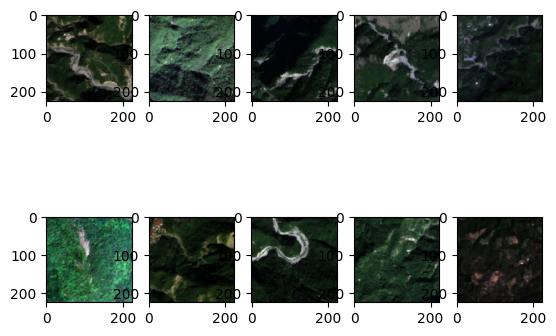

In [6]:
random_numbers = random.sample(range(num_files), 10)
fig, ax = plt.subplots(2,5)
ct = 0
for idx in random_numbers:
    ax[ct%2,ct//2].imshow(final_img_lst[idx])
    ct += 1

In [7]:
output_image_path = '/hdd/yuchen/satdata/land4sensor/resplit_data/'
file_list = glob.glob(output_image_path+'*.jpg')

random_seed = 42
random.seed(random_seed)
random.shuffle(file_list)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_files = len(file_list)

file_num_idx_dict = {
    'train': [0, round(total_files * train_ratio)],
    'valid': [round(total_files * train_ratio), 
              round(total_files * train_ratio) + round(total_files * val_ratio)],
    'test': [round(total_files * train_ratio) + round(total_files * val_ratio), total_files]
}

def copy_files(file_list, destination):
    for f in file_list:
        shutil.copy(f, destination)
        shutil.copy(f.split('.')[0] + '.xml', destination)

for set in ['test','train','valid']:
    img_path = '/hdd/yuchen/satdata/land4sensor/resplit_data'
    set_dir = '/hdd/yuchen/pipeline/training_pipeline/data_land4sensor/{}/'.format(set)

    files = [file for file in os.listdir(set_dir) if os.path.isfile(os.path.join(set_dir, file))]
    for file in files:
        os.remove(os.path.join(set_dir, file))
    
    set_files = file_list[file_num_idx_dict[set][0]:file_num_idx_dict[set][1]]
    copy_files(set_files, set_dir)


In [8]:
print('train', round(total_files * train_ratio))
print('val', round(total_files * val_ratio))
print('test', round(total_files * test_ratio))

train 1440
val 309
test 309


### sanity check

In [57]:
import random
output_image_path = '/hdd/yuchen/satdata/land4sensor/resplit_data/'
file_list = glob.glob(output_image_path+'*.jpg')

random_seed = 42
random.seed(random_seed)
random.shuffle(file_list)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_files = len(file_list)

train_files = round(total_files * train_ratio)
val_files = round(total_files * val_ratio)
test_files = total_files - train_files - val_files
print('train_files', train_files)
print('val_files', val_files)
print('test_files', test_files)


train_files 1236
val_files 265
test_files 265


In [ ]:
total_files = 3532

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of files for each set
train_files = round(total_files * train_ratio)
val_files = round(total_files * val_ratio)
test_files = total_files - train_files - val_files

train_files, val_files, test_files

IndexError: list index out of range

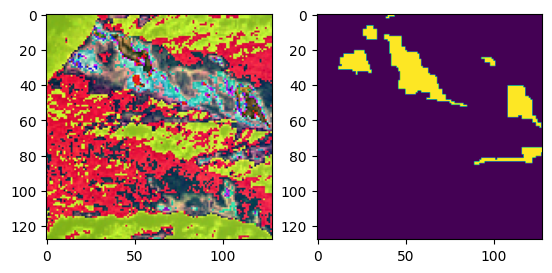

In [33]:
from matplotlib.patches import Rectangle

for i in range(2,4):
    fig, ax = plt.subplots(1,2)
    
    a = img_lst[i][np.array([3,2,1])]
    ax[0].imshow(np.transpose(np.array((a.transpose((2,1,0))*255), dtype=np.uint8),(1,0,2)))
    ax[1].imshow(label_lst[i])
    
    
    
    for bbox in bbox_lst[i]:  
        rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                         linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
    plt.show()


In [153]:
id = files[0].split('_')[1].split('.')[0]
f'{datafiles}/mask/mask_{id}.h5'

'/hdd/yuchen/satdata/land4sense/TrainData/mask/mask_3689.h5'

In [151]:
datafiles = '/hdd/yuchen/satdata/land4sensor/TrainData'
files = glob.glob(datafiles + '/mask/*')

with h5py.File(files[4], 'r') as hf:
    label = hf['mask'][:]

In [191]:
label.shape, temp.shape

((128, 128), (128, 128, 3))

In [17]:
# mask = label.astype(image.dtype)





array([[  3,  85,   6,  87],
       [ 37,  85,  40,  89],
       [ 67,  96,  69,  97],
       [ 48,  97,  52, 100],
       [126, 108, 128, 110]])

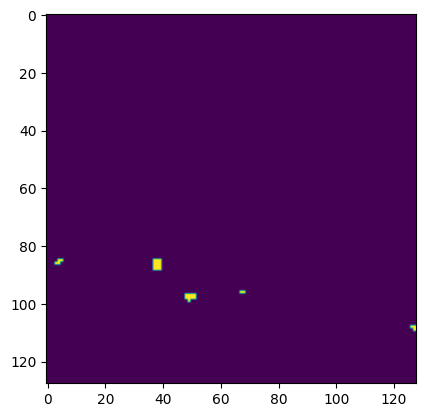

In [14]:
plt.imshow(label)

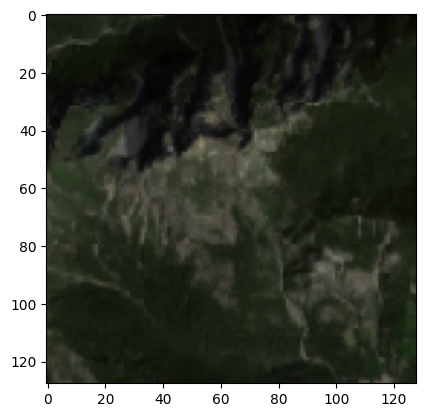

In [197]:
plt.imshow(image)

In [183]:
temp[:,:,channel].shape

(128, 128)

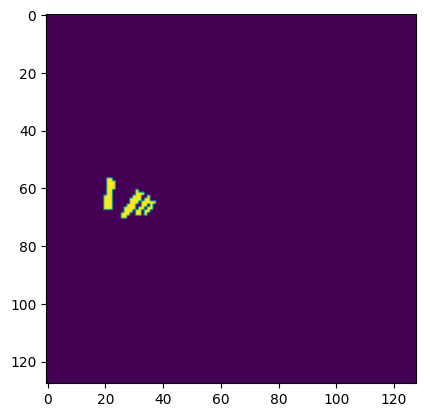

In [180]:
plt.imshow(label)

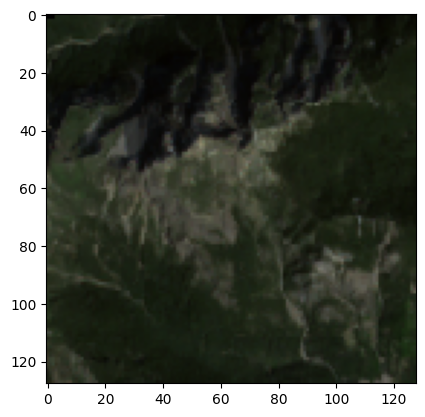

In [115]:
# for i in range(5):
#     plt.figure()
#     plt.imshow(np.transpose(img_lst[i][np.array([3,2,1])], (1,2,0)))

In [116]:
img_lst = np.array(img_lst)

for channel_idx in range(img_lst.shape[1]):
    channel = img_lst[:,channel_idx]
    min_val = np.min(channel)
    max_val = np.max(channel)

    for img_idx in range(img_lst.shape[0]):
        img_lst[img_idx, channel_idx] = (img_lst[img_idx, channel_idx] - min_val) / (max_val - min_val)

for i in range(5):
    plt.figure()
    img = img_lst[i][np.array([3,2,1])]
    image = Image.fromarray(np.transpose(np.array((img.transpose((2,1,0))*255), dtype=np.uint8),(1,0,2)), 'RGB')
    
    plt.imshow(image)


In [118]:
np.transpose(np.array((img.transpose((2,1,0))*255), dtype=np.uint8),(1,0,2)).shape

(128, 128, 3)

In [64]:
mean_ = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
std_ = [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]

image = np.asarray(image, np.float32)
# abel = np.asarray(label, np.float32)
image = image.transpose((-1, 0, 1))
size = image.shape

for i in range(len(mean_)):
    image[i,:,:] -= mean_[i]
    image[i,:,:] /= std_[i]

In [9]:
image.shape

(128, 128, 14)

In [10]:
img = image[:,:,np.array([3,2,1])].transpose((-1, 1, 0))

print(img.shape)
for i in range(img.shape[0]):
    channel = img[i]
    min_val = np.min(channel)
    max_val = np.max(channel)
    img[i] = (channel - min_val) / (max_val - min_val)

image = Image.fromarray(np.transpose(np.array((img.transpose((2,1,0))*255), dtype=np.uint8),(0,1,2)), 'RGB')
# image.save(output_image_path+str(filename)+'.jpg', 'JPEG')

(3, 128, 128)


In [11]:
img.shape

(3, 128, 128)

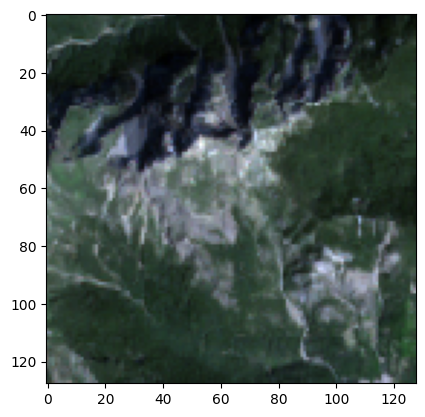

In [31]:
plt.imshow(img.transpose((2,1,0)))

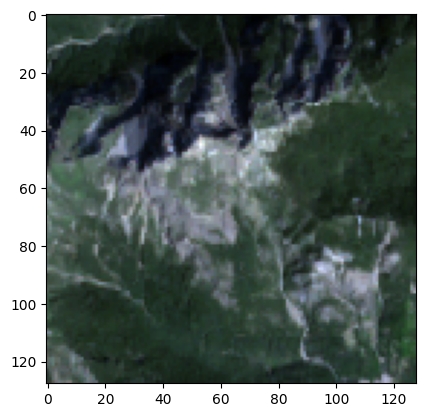

In [62]:
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


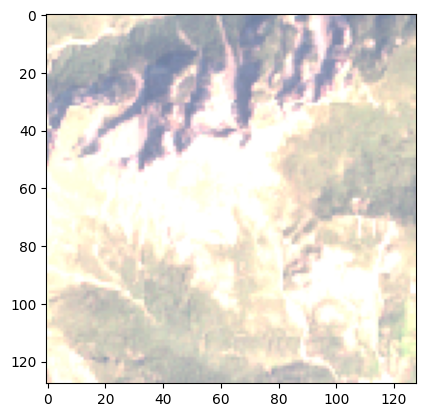

In [106]:
plt.imshow(image[:,:,np.array([3,2,1])])

## paper dataset

In [15]:
label_path = '/hdd/yuchen/satdata/paper_dataset/labels/'
image_path =  '/hdd/yuchen/satdata/paper_dataset/images/'

file_list = glob.glob(label_path+'*.xml')

random_seed = 42
random.seed(random_seed)
random.shuffle(file_list)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_files = len(file_list)

file_num_idx_dict = {
    'train': [0, round(total_files * train_ratio)],
    'valid': [round(total_files * train_ratio), 
              round(total_files * train_ratio) + round(total_files * val_ratio)],
    'test': [round(total_files * train_ratio) + round(total_files * val_ratio), total_files]
}

def copy_files(file_list, destination):
    for f in file_list:
        shutil.copy(f, destination)

for set in ['test','train','valid']:
    set_dir = '/hdd/yuchen/pipeline/training_pipeline/data_paper/{}/'.format(set)

    files = [file for file in os.listdir(set_dir) if os.path.isfile(os.path.join(set_dir, file))]
    for file in files:
        os.remove(os.path.join(set_dir, file))
    
    set_files = file_list[file_num_idx_dict[set][0]:file_num_idx_dict[set][1]]
    copy_files(set_files, set_dir)
    set_files_img = [f'{image_path}{f.split("/")[-1].split(".")[0]}.jpg' for f in set_files]
    copy_files(set_files_img, set_dir)
    

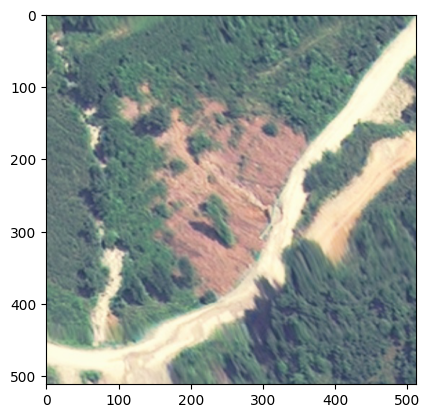

In [20]:
from PIL import Image
import IPython.display as display

image_path = '/hdd/yuchen/pipeline/training_pipeline/data_paper/test/*.jpg'  

# Open the image
img = Image.open(glob.glob(image_path)[0])
plt.imshow(img)